In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Add project root to sys.path for module imports
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
from src.utils.data_processing import create_mlp_train_and_test_datasets, create_lr_train_and_test_datasets, process_weather_data
from src.utils.dataset import Dataset
from src.utils.models import MLP, LinearRegressionModel
from src.utils.train_functions import train, evaluate, predict

# Load data

## Load parameter data

In [4]:
# Merge all dataframes
building_parameters = pd.read_csv("/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/data/building_parameters/building_parameters.csv")
building_parameters.set_index("building_id", inplace=True)

In [5]:
building_parameters.head()

,indoor_temp_param,consumption_param,ambient_temp_param,direct_solar_radiation_param,ambient_temp_lag_param
building_id,,,,,
10,0.988916,0.163115,-0.074399,0.000153,0.083117
122,0.955652,1.843034,-0.022571,0.000265,0.067082
129,0.951854,1.661780,0.196741,-0.000472,-0.139513
150,0.975725,0.863512,-0.194279,0.000443,0.214467
183,0.924559,1.000348,-0.118723,0.000107,0.203062


In [6]:
building_parameters.to_csv("/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/data/building_parameters/building_parameters.csv")

## ResStock data

In [7]:
processed_resstock = pd.read_csv("/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/data/resstock/resstock_processed.csv")
processed_resstock.set_index("bldg_id", inplace=True)
processed_resstock.sort_index(inplace=True)

# Create datasets

In [10]:
train_dataset, test_dataset = create_mlp_train_and_test_datasets(
    features=processed_resstock,
    labels=building_parameters,
    test_size=0.2,
)

In [11]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define model

In [12]:
# HYPERPARAMETERS
# model hyperparameters
input_size = len(processed_resstock.columns)
hidden_sizes = [64, 128, 128]
output_size = len(building_parameters.columns)

# training hyperparameters
num_epochs = 60
learning_rate = 0.0004

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
parameter_prediction_model = MLP(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
).to(device)

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(parameter_prediction_model.parameters(), lr=learning_rate)

## Train model

In [13]:
model_name = "parameter_prediction_model.pth"

In [ ]:
writer = SummaryWriter(log_dir=f"/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/runs/{model_name.replace('.pth', '')}")

In [ ]:
train(
    model=parameter_prediction_model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    writer=writer,
    verbose=True
)

## Evaluate model

In [ ]:
eval_loss = evaluate(
    model=parameter_prediction_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
)

In [ ]:
eval_loss

## Save model

In [14]:
models_path = "/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [ ]:
torch.save(parameter_prediction_model.state_dict(), os.path.join(models_path, model_name))
writer.close()

## Load model

In [15]:
model = MLP(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
).to(device)
model.load_state_dict(torch.load(os.path.join(models_path, model_name)))

<All keys matched successfully>

## Predict

In [120]:
sequences, labels = test_dataset[0]

In [121]:
predictions = predict(
    model=model,
    sequences=sequences,
    device=device,
)

# Test against Linear Regression models

## Load model parameters

In [122]:
actual_model = LinearRegressionModel(
    input_size=5,
    output_size=1,
    bias=False,
).to(device)

predicted_model = LinearRegressionModel(
    input_size=5,
    output_size=1,
    bias=False,
).to(device)

In [123]:
with torch.no_grad():
    actual_model.linear.weight.copy_(labels)
    predicted_model.linear.weight.copy_(predictions)

In [124]:
predictions_bldg_id = building_parameters[building_parameters.values == labels.cpu().numpy()].dropna(how='all').index[0]

## Load data

In [125]:
resstock = pd.read_parquet(
        "/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/data/resstock/resstock.parquet"
)

weather = pd.read_csv(
    "/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/data/weather/G2500170_2018.csv",
)

weather = process_weather_data(weather)

building_data_path = "/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/data/building_data"
filename = f"{predictions_bldg_id}-16.parquet"
building_data = pd.read_parquet(os.path.join(building_data_path, filename))

/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/src/utils/data_processing.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)


In [126]:
_, _, lr_test_data, lr_test_labels = create_lr_train_and_test_datasets(
                    building_data, resstock, weather, predictions_bldg_id
                )

/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/src/utils/data_processing.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption_timeseries["timestamp"] = pd.to_datetime(
/Users/cocoloco/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/4o/AI Lab/src/utils/data_processing.py:109: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  consumption_timeseries = consumption_timeseries.resample("H").mean()


In [127]:
lr_test_dataset = Dataset(
    features=lr_test_data,
    labels=lr_test_labels,
)

In [128]:
lr_test_loader = DataLoader(lr_test_dataset, batch_size=batch_size, shuffle=False)

In [129]:
actual_predictions = predict(
    model=actual_model,
    sequences=lr_test_loader,
    device=device,
)

In [130]:
predicted_predictions = predict(
    model=predicted_model,
    sequences=lr_test_loader,
    device=device,
)

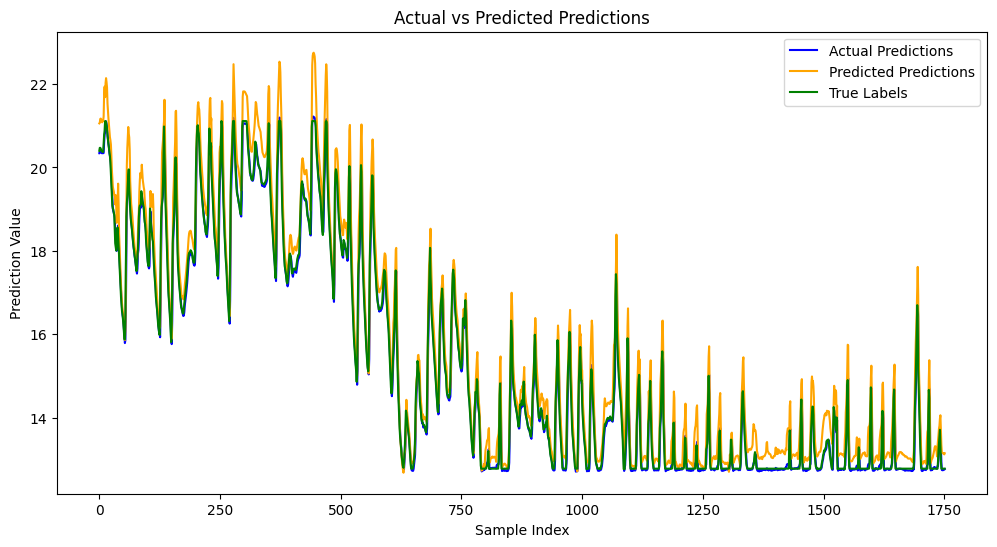

In [131]:
# plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_predictions.cpu().numpy(), label='Actual Predictions', color='blue')
plt.plot(predicted_predictions.cpu().numpy(), label='Predicted Predictions', color='orange')
plt.plot(lr_test_labels, label='True Labels', color='green')
plt.title('Actual vs Predicted Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Value')
plt.legend()
plt.show()